<a href="https://colab.research.google.com/github/1489685175z-coder/Bird_Speicy_Classification/blob/main/Bird_Speicy_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Project: Fine-Grained Bird Species Classification on CUB-200-2011
# Compare: Pretrained ResNet-18 vs Pretrained ViT

# =============================================================================
# 1. Install dependencies (if needed in Colab)
# =============================================================================
!pip install -q transformers datasets torch torchvision scikit-learn matplotlib pillow tqdm evaluate
!pip install seaborn
# =============================================================================
# 2. Import libraries
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from transformers import ViTForImageClassification
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, top_k_accuracy_score, classification_report, confusion_matrix
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd

In [9]:
# =============================================================================
# 3. Device & Hyperparameters
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 32  # Compromise between originals (16 for ViT, 64 for ResNet)
NUM_EPOCHS = 30   # Balanced for comparison
NUM_CLASSES = 200

models_config = [
    {"name": "resnet18", "pretrained": True, "lr": 0.001},
    {"name": "vit", "pretrained": True, "lr": 3e-5}
]


Using device: cuda


In [10]:
# =============================================================================
# 4. Load Dataset from Hugging Face
# =============================================================================
print("Loading dataset...")
hf_dataset = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")

class_names = hf_dataset['train'].features['label'].names  # Get class names for reporting

class CUBDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image'].convert('RGB')
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_train_ds = CUBDataset(hf_dataset['train'], train_transform)
test_ds = CUBDataset(hf_dataset['test'], test_transform)

train_size = int(0.85 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}, Test samples: {len(test_ds)}")
print(f"Num classes: {NUM_CLASSES}, Example classes: {class_names[:5]}...")


Loading dataset...
Train samples: 5094, Val samples: 900, Test samples: 5794
Num classes: 200, Example classes: ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet']...


In [11]:
# =============================================================================
# 5. Train and Evaluate Functions (Unified for both models)
# =============================================================================
def train_epoch(model, loader, criterion, optimizer, scaler, device, model_name):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            if model_name == "vit":
                outputs = model(pixel_values=images).logits
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * images.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += images.size(0)
    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device, model_name, is_test=False):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_logits = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            if model_name == "vit":
                outputs = model(pixel_values=images).logits
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += images.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            if is_test:
                all_logits.extend(outputs.cpu().numpy())  # For top-5
    acc = correct / total
    loss = total_loss / total
    top5_acc = top_k_accuracy_score(all_labels, all_logits, k=5) if is_test else None
    return loss, acc, top5_acc, all_preds, all_labels


In [12]:
# =============================================================================
# 6. Main Training Loop
# =============================================================================
all_history = {}
test_results = {}
for config in models_config:
    name = config["name"]
    print(f"\n=== Training {name} ===")
    if name == "resnet18":
        model = models.resnet18(pretrained=config["pretrained"])
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
        # Freeze all except last layer and classifier (as in original ResNet)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True

    elif name == "vit":
        model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k",
            num_labels=NUM_CLASSES,
            ignore_mismatched_sizes=True
        )
        # No freezing in original ViT, so train all with small LR

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=0.01)
    scaler = torch.cuda.amp.GradScaler(enabled=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "train_time": []}
    best_val_acc = 0.0
    t_start = time.time()

    for epoch in range(NUM_EPOCHS):
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device, name)
        va_loss, va_acc, _, _, _ = evaluate(model, val_loader, criterion, device, name)
        scheduler.step(va_acc)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
        epoch_time = time.time() - t_start
        history["train_time"].append(epoch_time)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            torch.save(model.state_dict(), f"best_{name}.pth")

    total_train_time = time.time() - t_start
    print(f"Total training time for {name}: {total_train_time:.1f}s")

    # Load best model for test
    model.load_state_dict(torch.load(f"best_{name}.pth", map_location=device))
    te_loss, te_acc, te_top5_acc, te_preds, te_labels = evaluate(model, test_loader, criterion, device, name, is_test=True)
    report = classification_report(te_labels, te_preds, target_names=class_names, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']

    test_results[name] = {
        "acc": te_acc,
        "top5_acc": te_top5_acc,
        "macro_f1": macro_f1,
        "train_time": total_train_time,
        "preds": te_preds,
        "labels": te_labels
    }
    all_history[name] = history

    # Per-model error analysis (top-5 confused pairs)
    errors = [(true, pred) for true, pred in zip(te_labels, te_preds) if true != pred]
    if errors:
        most_common_errors = Counter(errors).most_common(5)
        print(f"Top 5 confused pairs for {name} (True → Predicted):")
        for (true_label, pred_label), count in most_common_errors:
            true_name = class_names[true_label]
            pred_name = class_names[pred_label]
            print(f"  {true_name} → {pred_name} : {count} times")


=== Training resnet18 ===


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-3482151153.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
Training:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipython-input-838357888.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

Epoch 1/30 | Train Loss: 4.4131 Acc: 0.1227 | Val Loss: 3.6645 Acc: 0.2500


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]


Epoch 2/30 | Train Loss: 3.3113 Acc: 0.3147 | Val Loss: 3.2139 Acc: 0.3178


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]


Epoch 3/30 | Train Loss: 2.9849 Acc: 0.4009 | Val Loss: 3.1517 Acc: 0.3944


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.48it/s]


Epoch 4/30 | Train Loss: 2.7822 Acc: 0.4609 | Val Loss: 3.0364 Acc: 0.3944


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.18it/s]


Epoch 5/30 | Train Loss: 2.5847 Acc: 0.5261 | Val Loss: 2.8577 Acc: 0.4511


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.22it/s]


Epoch 6/30 | Train Loss: 2.4598 Acc: 0.5626 | Val Loss: 2.8177 Acc: 0.4744


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.25it/s]


Epoch 7/30 | Train Loss: 2.3739 Acc: 0.5885 | Val Loss: 2.7621 Acc: 0.4811


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.07it/s]


Epoch 8/30 | Train Loss: 2.2520 Acc: 0.6229 | Val Loss: 2.7941 Acc: 0.4767


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.06it/s]


Epoch 9/30 | Train Loss: 2.2141 Acc: 0.6378 | Val Loss: 2.7987 Acc: 0.4822


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.66it/s]


Epoch 10/30 | Train Loss: 2.1279 Acc: 0.6639 | Val Loss: 2.8092 Acc: 0.4744


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]


Epoch 11/30 | Train Loss: 2.0650 Acc: 0.6959 | Val Loss: 2.7566 Acc: 0.4922


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]


Epoch 12/30 | Train Loss: 2.0473 Acc: 0.6985 | Val Loss: 2.8087 Acc: 0.4767


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


Epoch 13/30 | Train Loss: 2.0067 Acc: 0.7087 | Val Loss: 2.7345 Acc: 0.5167


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


Epoch 14/30 | Train Loss: 1.9838 Acc: 0.7191 | Val Loss: 2.8173 Acc: 0.4822


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s]


Epoch 15/30 | Train Loss: 1.9302 Acc: 0.7346 | Val Loss: 2.7303 Acc: 0.5144


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.21it/s]


Epoch 16/30 | Train Loss: 1.8801 Acc: 0.7532 | Val Loss: 2.7800 Acc: 0.4989


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.37it/s]


Epoch 17/30 | Train Loss: 1.7388 Acc: 0.8074 | Val Loss: 2.5005 Acc: 0.5678


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]


Epoch 18/30 | Train Loss: 1.6760 Acc: 0.8204 | Val Loss: 2.5576 Acc: 0.5467


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


Epoch 19/30 | Train Loss: 1.6369 Acc: 0.8316 | Val Loss: 2.6019 Acc: 0.5567


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.33it/s]


Epoch 20/30 | Train Loss: 1.6554 Acc: 0.8251 | Val Loss: 2.5767 Acc: 0.5544


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  4.98it/s]


Epoch 21/30 | Train Loss: 1.5740 Acc: 0.8543 | Val Loss: 2.5261 Acc: 0.5878


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.01it/s]


Epoch 22/30 | Train Loss: 1.5183 Acc: 0.8679 | Val Loss: 2.5261 Acc: 0.5744


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.17it/s]


Epoch 23/30 | Train Loss: 1.5095 Acc: 0.8687 | Val Loss: 2.5133 Acc: 0.5700


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.11it/s]


Epoch 24/30 | Train Loss: 1.5183 Acc: 0.8644 | Val Loss: 2.5986 Acc: 0.5667


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  4.90it/s]


Epoch 25/30 | Train Loss: 1.5080 Acc: 0.8724 | Val Loss: 2.5243 Acc: 0.5800


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.19it/s]


Epoch 26/30 | Train Loss: 1.4747 Acc: 0.8820 | Val Loss: 2.5739 Acc: 0.5578


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


Epoch 27/30 | Train Loss: 1.4515 Acc: 0.8816 | Val Loss: 2.5614 Acc: 0.5733


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.18it/s]


Epoch 28/30 | Train Loss: 1.4677 Acc: 0.8783 | Val Loss: 2.5488 Acc: 0.5578


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


Epoch 29/30 | Train Loss: 1.4435 Acc: 0.8850 | Val Loss: 2.6222 Acc: 0.5511


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.53it/s]


Epoch 30/30 | Train Loss: 1.4342 Acc: 0.8912 | Val Loss: 2.5862 Acc: 0.5611
Total training time for resnet18: 1225.9s


Evaluating: 100%|██████████| 182/182 [00:30<00:00,  6.01it/s]


Top 5 confused pairs for resnet18 (True → Predicted):
  025.Pelagic_Cormorant → 023.Brandt_Cormorant : 14 times
  051.Horned_Grebe → 050.Eared_Grebe : 12 times
  107.Common_Raven → 029.American_Crow : 11 times
  185.Bohemian_Waxwing → 186.Cedar_Waxwing : 10 times
  102.Western_Wood_Pewee → 040.Olive_sided_Flycatcher : 9 times

=== Training vit ===


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224-in21k
Key                 | Status     | 
--------------------+------------+-
pooler.dense.weight | UNEXPECTED | 
pooler.dense.bias   | UNEXPECTED | 
classifier.bias     | MISSING    | 
classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/tmp/ipython-input-3482151153.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
Training:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipython-input-838357888.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enab

Epoch 1/30 | Train Loss: 5.1987 Acc: 0.0870 | Val Loss: 5.0642 Acc: 0.2622


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.77it/s]


Epoch 2/30 | Train Loss: 4.8882 Acc: 0.4321 | Val Loss: 4.7495 Acc: 0.5022


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 3/30 | Train Loss: 4.5550 Acc: 0.5850 | Val Loss: 4.4486 Acc: 0.5811


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.75it/s]


Epoch 4/30 | Train Loss: 4.2411 Acc: 0.6466 | Val Loss: 4.1845 Acc: 0.5711


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.82it/s]


Epoch 5/30 | Train Loss: 3.9398 Acc: 0.6920 | Val Loss: 3.8888 Acc: 0.6311


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.73it/s]


Epoch 6/30 | Train Loss: 3.6514 Acc: 0.7189 | Val Loss: 3.6511 Acc: 0.6344


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.78it/s]


Epoch 7/30 | Train Loss: 3.3669 Acc: 0.7313 | Val Loss: 3.3957 Acc: 0.6467


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.75it/s]


Epoch 8/30 | Train Loss: 3.0898 Acc: 0.7585 | Val Loss: 3.1805 Acc: 0.6378


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 9/30 | Train Loss: 2.8423 Acc: 0.7774 | Val Loss: 2.9149 Acc: 0.6656


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.77it/s]


Epoch 10/30 | Train Loss: 2.6150 Acc: 0.7880 | Val Loss: 2.7135 Acc: 0.6867


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.78it/s]


Epoch 11/30 | Train Loss: 2.3871 Acc: 0.8078 | Val Loss: 2.5997 Acc: 0.6800


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 12/30 | Train Loss: 2.2042 Acc: 0.8157 | Val Loss: 2.3435 Acc: 0.7267


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 13/30 | Train Loss: 2.0458 Acc: 0.8245 | Val Loss: 2.3134 Acc: 0.7100


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 14/30 | Train Loss: 1.8975 Acc: 0.8430 | Val Loss: 2.1997 Acc: 0.7167


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.77it/s]


Epoch 15/30 | Train Loss: 1.7795 Acc: 0.8522 | Val Loss: 2.0537 Acc: 0.7333


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 16/30 | Train Loss: 1.6686 Acc: 0.8628 | Val Loss: 1.9771 Acc: 0.7400


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.72it/s]


Epoch 17/30 | Train Loss: 1.5733 Acc: 0.8783 | Val Loss: 1.8396 Acc: 0.7644


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 18/30 | Train Loss: 1.5308 Acc: 0.8730 | Val Loss: 1.8589 Acc: 0.7300


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.71it/s]


Epoch 19/30 | Train Loss: 1.4590 Acc: 0.8848 | Val Loss: 1.8217 Acc: 0.7578


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 20/30 | Train Loss: 1.4232 Acc: 0.8806 | Val Loss: 1.8019 Acc: 0.7600


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.66it/s]


Epoch 21/30 | Train Loss: 1.3557 Acc: 0.9013 | Val Loss: 1.7388 Acc: 0.7556


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 22/30 | Train Loss: 1.3425 Acc: 0.9062 | Val Loss: 1.7509 Acc: 0.7422


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.66it/s]


Epoch 23/30 | Train Loss: 1.3265 Acc: 0.9042 | Val Loss: 1.7168 Acc: 0.7633


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 24/30 | Train Loss: 1.2746 Acc: 0.9136 | Val Loss: 1.6998 Acc: 0.7689


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.68it/s]


Epoch 25/30 | Train Loss: 1.2788 Acc: 0.9134 | Val Loss: 1.7573 Acc: 0.7522


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.74it/s]


Epoch 26/30 | Train Loss: 1.2661 Acc: 0.9142 | Val Loss: 1.6618 Acc: 0.7589


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.74it/s]


Epoch 27/30 | Train Loss: 1.2215 Acc: 0.9299 | Val Loss: 1.7018 Acc: 0.7589


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.74it/s]


Epoch 28/30 | Train Loss: 1.2386 Acc: 0.9213 | Val Loss: 1.6510 Acc: 0.7722


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 29/30 | Train Loss: 1.2238 Acc: 0.9227 | Val Loss: 1.6674 Acc: 0.7689


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.63it/s]


Epoch 30/30 | Train Loss: 1.2135 Acc: 0.9282 | Val Loss: 1.6032 Acc: 0.7856
Total training time for vit: 1761.5s


Evaluating: 100%|██████████| 182/182 [01:03<00:00,  2.85it/s]


Top 5 confused pairs for vit (True → Predicted):
  059.California_Gull → 066.Western_Gull : 13 times
  071.Long_tailed_Jaeger → 072.Pomarine_Jaeger : 13 times
  025.Pelagic_Cormorant → 024.Red_faced_Cormorant : 11 times
  146.Forsters_Tern → 144.Common_Tern : 10 times
  009.Brewer_Blackbird → 027.Shiny_Cowbird : 9 times



=== Model Comparison ===
| Model    |   Test Accuracy |   Test Top-5 Accuracy |   Macro F1-Score |   Total Train Time (s) |
|:---------|----------------:|----------------------:|-----------------:|-----------------------:|
| resnet18 |          0.6845 |                0.8942 |           0.6827 |                 1225.9 |
| vit      |          0.8742 |                0.9789 |           0.8728 |                 1761.5 |


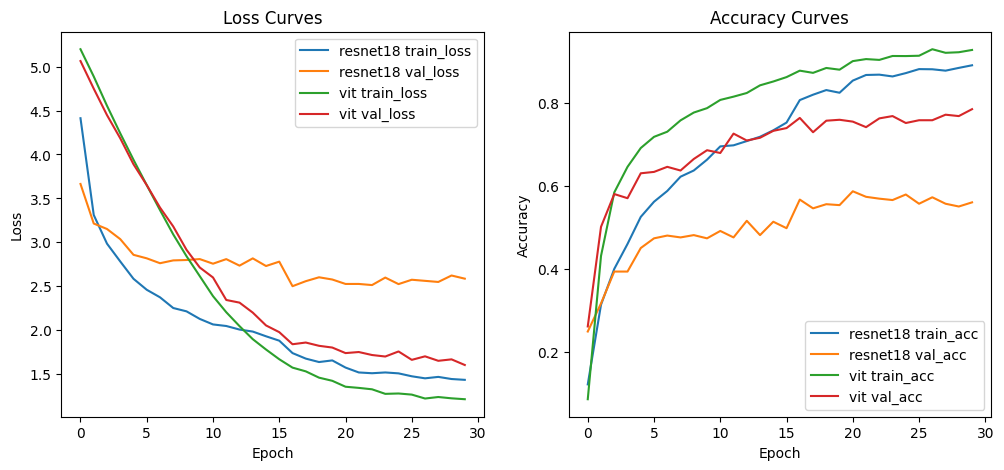

In [13]:

# =============================================================================
# 7. Compare Models
# =============================================================================
print("\n=== Model Comparison ===")
comparison_data = {
    "Model": list(test_results.keys()),
    "Test Accuracy": [f"{test_results[m]['acc']:.4f}" for m in test_results],
    "Test Top-5 Accuracy": [f"{test_results[m]['top5_acc']:.4f}" for m in test_results],
    "Macro F1-Score": [f"{test_results[m]['macro_f1']:.4f}" for m in test_results],
    "Total Train Time (s)": [f"{test_results[m]['train_time']:.1f}" for m in test_results]
}
print(pd.DataFrame(comparison_data).to_markdown(index=False))  # Requires import pandas as pd if needed

# Plot combined curves
plt.figure(figsize=(12, 5))
for name in all_history:
    plt.subplot(1, 2, 1)
    plt.plot(all_history[name]["train_loss"], label=f"{name} train_loss")
    plt.plot(all_history[name]["val_loss"], label=f"{name} val_loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_history[name]["train_acc"], label=f"{name} train_acc")
    plt.plot(all_history[name]["val_acc"], label=f"{name} val_acc")
    plt.title("Accuracy Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
plt.show()


=== Plotting Confusion Matrices ===


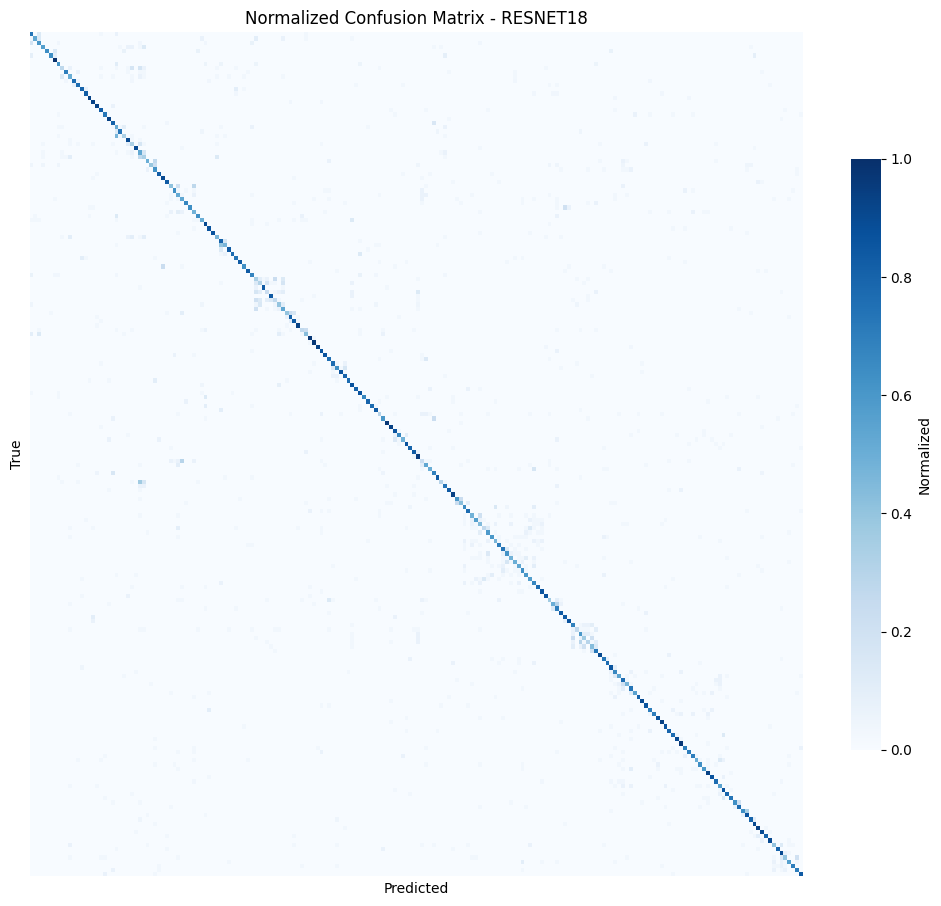

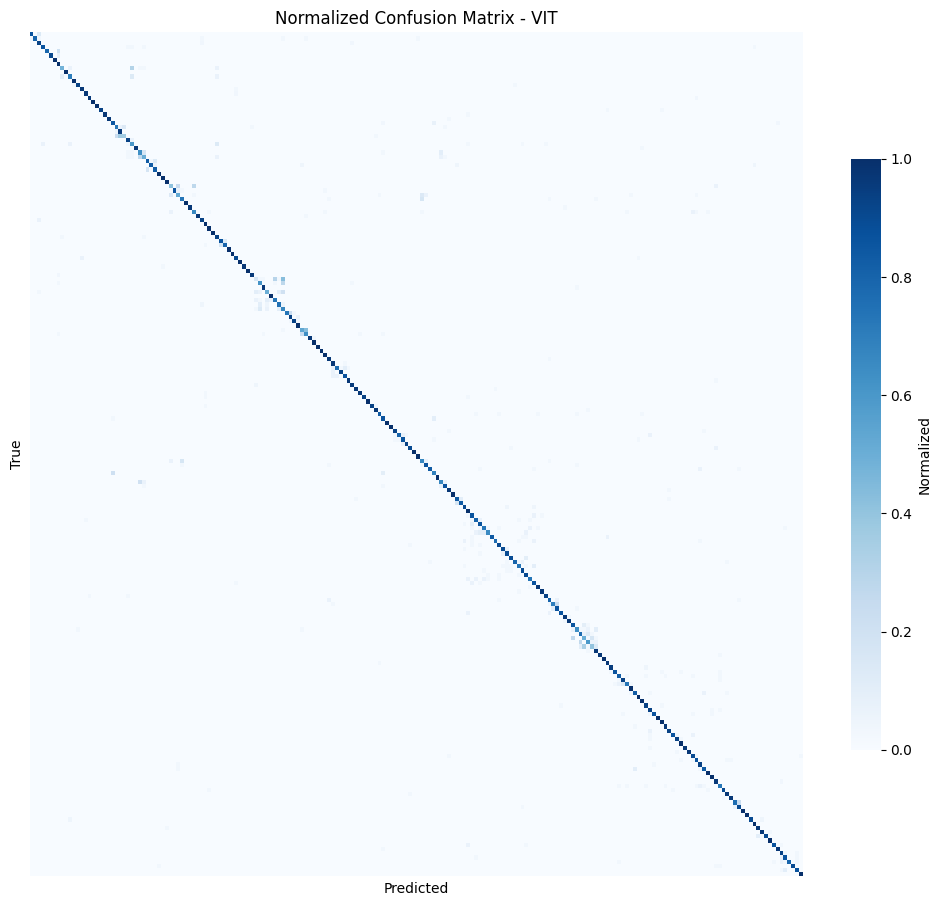

In [14]:
# =============================================================================
# 8. Plot Confusion Matrices for Both Models
# =============================================================================
print("\n=== Plotting Confusion Matrices ===")

for name in test_results:
    y_true = test_results[name]['labels']   # list or np.array of true labels
    y_pred = test_results[name]['preds']    # list or np.array of predicted labels

    # Compute Confusion Matrice (200x200)
    cm = confusion_matrix(y_true, y_pred)

    # Normalized (row-normalized to 1, easier to see error distribution)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)


    plt.figure(figsize=(10, 9))
    sns.heatmap(
        cm_normalized,
        cmap='Blues',
        annot=False,
        xticklabels=False,
        yticklabels=False,
        square=False,
        cbar_kws={'label': 'Normalized', 'shrink': 0.7}
    )
    plt.title(f'Normalized Confusion Matrix - {name.upper()}', fontsize=12)
    plt.ylabel('True', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.tight_layout(pad=0.5)
    plt.savefig(f'cm_{name}_small.png', dpi=200, bbox_inches='tight')
    plt.show()